<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting UVI with LSTMs

[Notebook 0: Data Cleaning](./0_DataCleaning.ipynb)

[Notebook 1: EDA](./1_EDA.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling_and_Predictions.ipynb)

[Notebook 3: Technical Report](./3_Technical_Report.ipynb)

Was wird in diesem Notebook gemacht?

## Verbinden mit der Google Drive und Import der benötigten Module:

In [ ]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 37.9 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.0-py2.py3-none-any.whl size=42486 sha256=380e58fbd39696aa4cf17d54a9b0dfd169e58d5d478f1d2a16ff835c12e2f4c8
  Stored in directory: /root/.cache/pip/wheels/74/a2/6c/26fb1addf1ce6c60a8cef8397f2999f0a1e6e2fcddc8abf33e
Successfully built factor_analyzer


In [ ]:
## import modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

# Bib für PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

import matplotlib
import seaborn as sns

In [ ]:
# Größe der Plots festlegen
matplotlib.rcParams['figure.figsize'] = (13, 8)

In [ ]:
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

In [ ]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
output_plot_path = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

In [ ]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)

df_UVI.index = pd.to_datetime(df_UVI.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)

# NaN Einträge durch 0 ersetzen
df_UVI['UVI'] = df_UVI['UVI'].fillna(0)
df_UVI['erythem'] = df_UVI['erythem'].fillna(0)

In [ ]:
# Stündlicher Durchschitt ohne Nullen
df_UVI_hourly = df_UVI[df_UVI['UVI'] != 0][['UVI','erythem', 'SZA']].resample('H').mean()

In [ ]:
# Stündlicher Durchschitt mit Nullen
df_UVI_hourly_withZero = df_UVI[['UVI','erythem', 'SZA']].resample('H').mean()

## Allgemeine Informationen:

In [ ]:
# Allgemeine Informationen über die Messdaten
round(df_UVI.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,110348.0,5.517350e+04,3.185487e+04,0.00,27586.75,55173.50,82760.25,1.103470e+05
Messzeitpunkt,110348.0,4.042783e+04,1.321452e+04,12360.00,29700.00,40440.00,51180.00,6.822000e+04
erythem,110348.0,1.936525e+128,4.629360e+130,0.00,0.00,0.01,0.04,1.270545e+133
UVI,110348.0,7.746101e+129,1.851744e+132,0.00,0.14,0.56,1.79,5.082182e+134
DiffGreater2,110348.0,1.000000e-02,1.100000e-01,0.00,0.00,0.00,0.00,1.000000e+00
SZA,110348.0,6.507000e+01,1.680000e+01,27.36,52.65,68.04,78.22,9.787000e+01
time_sin,110348.0,1.200000e-01,7.000000e-01,-1.00,-0.55,0.20,0.83,1.000000e+00
time_cos,110348.0,-5.900000e-01,3.900000e-01,-1.00,-0.93,-0.71,-0.35,6.200000e-01
date_sin,110348.0,-3.000000e-02,7.200000e-01,-1.00,-0.73,-0.13,0.74,1.000000e+00
date_cos,110348.0,-1.000000e-01,6.900000e-01,-1.00,-0.77,-0.17,0.56,1.000000e+00


In [ ]:
# Allgemeine Informationen über die Vorhersagedaten
round(df_CAMS.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
aod469,3964.0,0.19,0.14,0.02,0.09,0.15,0.24,1.31
aod550,3964.0,0.15,0.12,0.01,0.08,0.12,0.20,1.08
aod670,3964.0,0.12,0.09,0.01,0.06,0.09,0.15,0.82
aod865,3964.0,0.01,0.00,0.00,0.01,0.01,0.01,0.01
uvbed,3964.0,1.22,1.55,-0.00,0.11,0.55,1.75,7.56
uvbedcs,3964.0,1.64,1.85,-0.00,0.21,0.83,2.57,7.67
hcc,3964.0,0.43,0.42,0.00,0.00,0.28,0.94,1.00
lcc,3964.0,0.42,0.40,0.00,0.01,0.28,0.89,1.00
mcc,3964.0,0.31,0.36,0.00,0.00,0.14,0.59,1.00
tcc,3964.0,0.72,0.35,0.00,0.45,0.94,1.00,1.00


In [ ]:
# Prüfen, ob es Nullwerte in den Daten gibt
print(df_UVI.info(), '\n --------------------- \n', df_UVI.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 110348 entries, 2022-06-15 07:21:00 to 2023-05-26 09:12:00
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     110348 non-null  int64  
 1   Datum          110348 non-null  object 
 2   Uhrzeit        110348 non-null  object 
 3   Messzeitpunkt  110348 non-null  float64
 4   erythem        110348 non-null  float64
 5   UVI            110348 non-null  float64
 6   DiffGreater2   110348 non-null  float64
 7   SZA            110348 non-null  float64
 8   time_sin       110348 non-null  float64
 9   time_cos       110348 non-null  float64
 10  date_sin       110348 non-null  float64
 11  date_cos       110348 non-null  float64
 12  Date           110348 non-null  object 
 13  Hour           110348 non-null  int64  
dtypes: float64(9), int64(2), object(3)
memory usage: 12.6+ MB
None 
 --------------------- 
 Unnamed: 0       0
Datum            0
Uhr

In [ ]:
# Allgemeine Informationen über die stünlich aufgelösten Messdaten
df_UVI_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8283 entries, 2022-06-15 07:00:00 to 2023-05-26 09:00:00
Freq: H
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UVI      3936 non-null   float64
 1   erythem  3936 non-null   float64
 2   SZA      3936 non-null   float64
dtypes: float64(3)
memory usage: 258.8 KB


In [ ]:

df_UVI_hourly_withZero.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8283 entries, 2022-06-15 07:00:00 to 2023-05-26 09:00:00
Freq: H
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UVI      3964 non-null   float64
 1   erythem  3964 non-null   float64
 2   SZA      3964 non-null   float64
dtypes: float64(3)
memory usage: 258.8 KB


In [ ]:
df_CAMS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3964 entries, 2022-06-15 07:00:00 to 2023-05-26 09:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   aod469   3964 non-null   float64
 1   aod550   3964 non-null   float64
 2   aod670   3964 non-null   float64
 3   aod865   3964 non-null   float64
 4   uvbed    3964 non-null   float64
 5   uvbedcs  3964 non-null   float64
 6   hcc      3964 non-null   float64
 7   lcc      3964 non-null   float64
 8   mcc      3964 non-null   float64
 9   tcc      3964 non-null   float64
 10  cbh      3378 non-null   float64
dtypes: float64(11)
memory usage: 371.6 KB


## Plotten der Dataframes:

### Plot der Tagesdurchschnitte:

<ipython-input-16-ced9c66472a7>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_UVI.groupby('Date').sum()[['UVI']].plot()


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(-50.0, 0, '2023-04-04'),
  Text(0.0, 0, '2022-06-15'),
  Text(50.0, 0, '2022-08-05'),
  Text(100.0, 0, '2022-10-01'),
  Text(150.0, 0, '2022-11-21'),
  Text(200.0, 0, '2023-01-20'),
  Text(250.0, 0, '2023-03-11'),
  Text(300.0, 0, '2023-05-04'),
  Text(350.0, 0, '')])

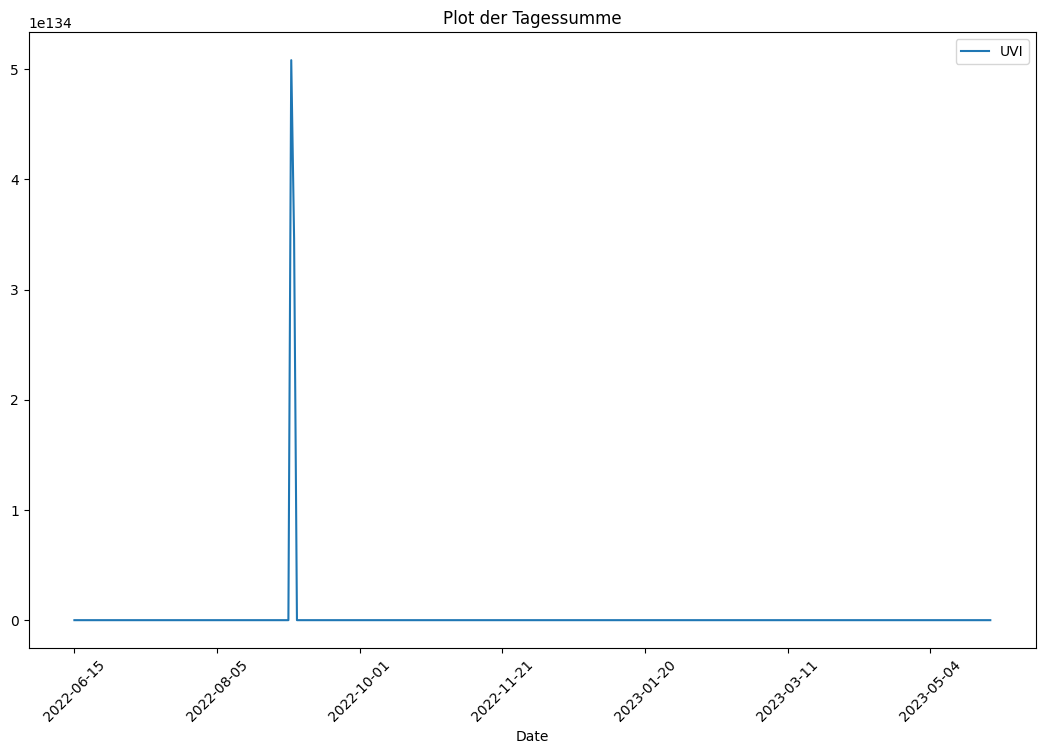

In [ ]:
# Plot der Tagessumme
df_UVI.groupby('Date').sum()[['UVI']].plot()
plt.title('Plot der Tagessumme');
plt.xticks(rotation=45)

<ipython-input-17-0fba8228a8f9>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_UVI.groupby('Uhrzeit').mean()[['UVI']].plot()


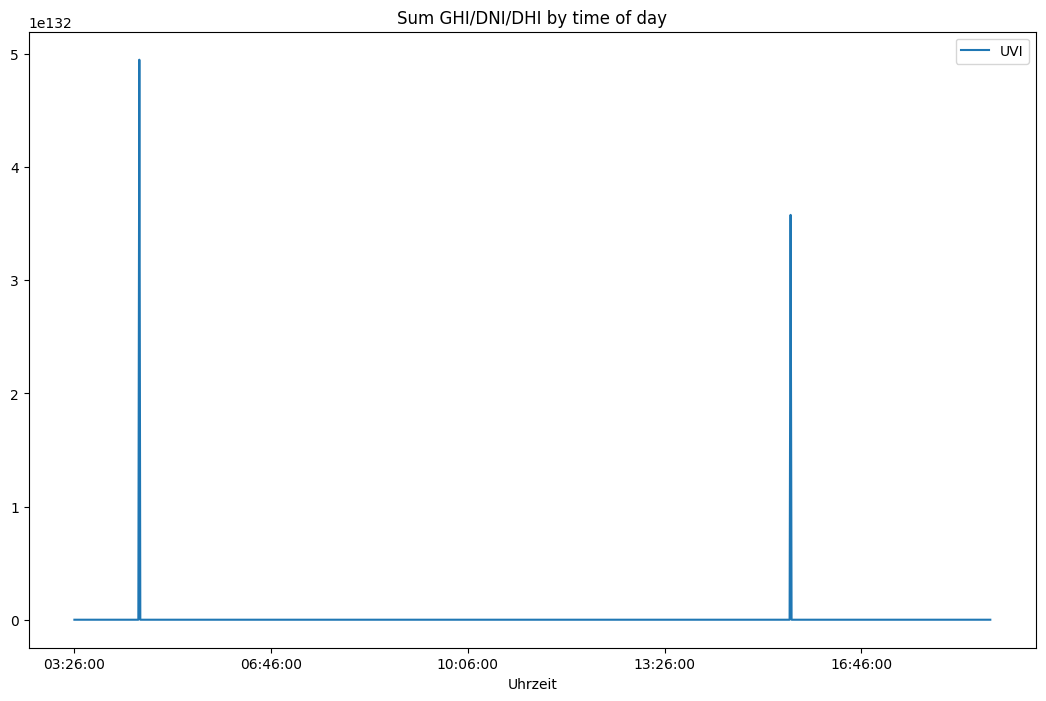

In [ ]:
# Average DNI/GHI/DHI over DOY.
df_UVI.groupby('Uhrzeit').mean()[['UVI']].plot()
plt.title('Sum GHI/DNI/DHI by time of day');

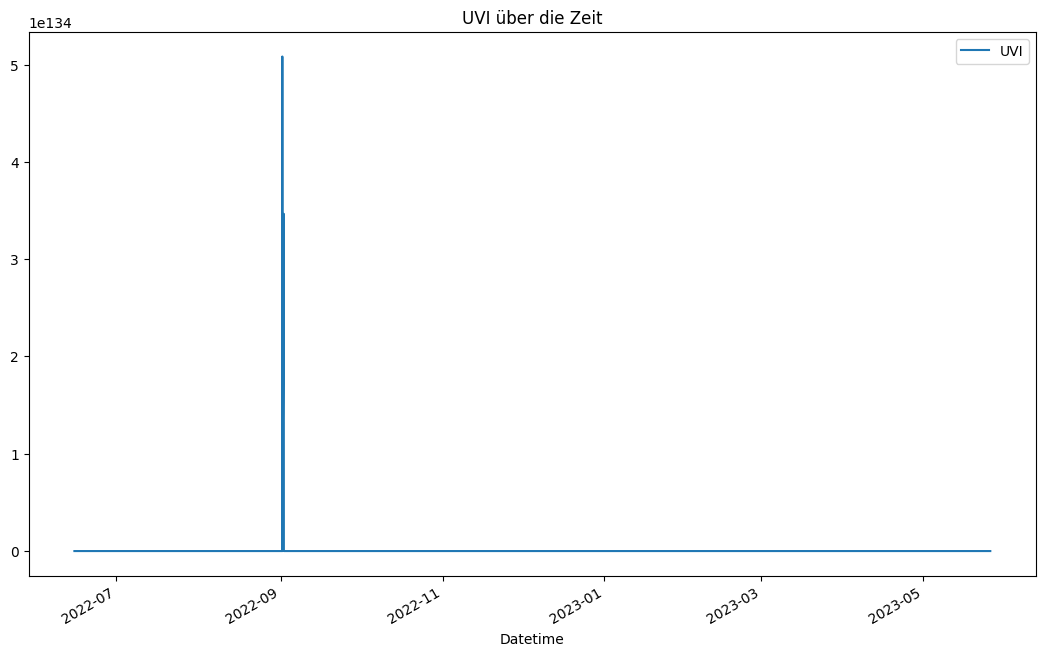

In [ ]:
# Irradiance metrics over time
df_UVI[['UVI']].plot()
plt.title('UVI über die Zeit');

In [ ]:
def plot_daily_mean_data(df1, df2, value_column1='UVI', value_column2='Wert2'):

    # Resample auf tägliche Auflösung und Berechnung des Durchschnitts
    df1_daily = df1.resample('D').mean()
    df2_daily = df2.resample('D').mean()

    # Erstellen Sie den Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df1_daily.index, df1_daily[value_column1], label='DataFrame 1', marker='o')
    plt.plot(df2_daily.index, df2_daily[value_column2], label='DataFrame 2', marker='x')

    plt.title('Tägliche Messwerte')
    plt.xlabel('Datum')
    plt.ylabel('Durchschnittlicher Messwert')
    plt.legend()
    plt.grid(True)

    # Rotieren Sie die X-Achsenbeschriftungen für bessere Lesbarkeit
    plt.xticks(rotation=45)

    # Zeigen Sie den Plot an
    plt.tight_layout()
    plt.show()

In [ ]:
# plot_daily_mean_data(df_UVI, df_CAMS)

### Plot der täglichen Verläufe:

In [ ]:
df_plot_daily = pd.concat([df_UVI[['UVI', 'SZA']], df_CAMS[['aod469', 'uvbed', 'uvbedcs', 'tcc']]], axis = 1)

In [ ]:
def create_daily_plots(df, columns_to_plot):
    # Gruppieren nach Tag
    grouped = df.groupby(df.index.date)

    # Stil für Seaborn-Plots festlegen
    sns.set(style="darkgrid")

    for date, group in grouped:
        fig, ax1 = plt.subplots(figsize=(10, 6))  # Hauptfigur und erste Achse erstellen

        twin1 = ax1.twinx()
        twin2 = ax1.twinx()
        twin3 = ax1.twinx()
        twin4 = ax1.twinx()

        twin1.spines.right.set_position(("axes", 1))
        twin2.spines.right.set_position(("axes", 1.1))
        twin3.spines.right.set_position(("axes", 1.22))
        twin4.spines.right.set_position(("axes", 1.33))

        # Erste Achse erstellen (links)
        sns.set(style="whitegrid")

        # # Zweiter Plot mit Seaborn auf der zweiten Y-Achse
        sns.lineplot(data=df, x=df.index, y='UVI', label='UVI', marker='o', color='b', ax=ax1)

        sns.lineplot(data=df, x=df.index, y='SZA', label='SZA', marker='o', color='r', ax=twin1)

        sns.lineplot(data=df, x=df.index, y='uvbed', label='UVI', marker='o', color='g', ax=twin2)

        sns.lineplot(data=df, x=df.index, y='uvbedcs', label='UVI CS', marker='o', color='k', ax=twin3)

        sns.lineplot(data=df, x=df.index, y='tcc', label='TCC', marker='o', color='y', ax=twin4)

        plt.xlabel('Uhrzeit')
        plt.legend(loc='upper left')
        plt.title(f'Tagesverlauf für den {date}')
        plt.show()

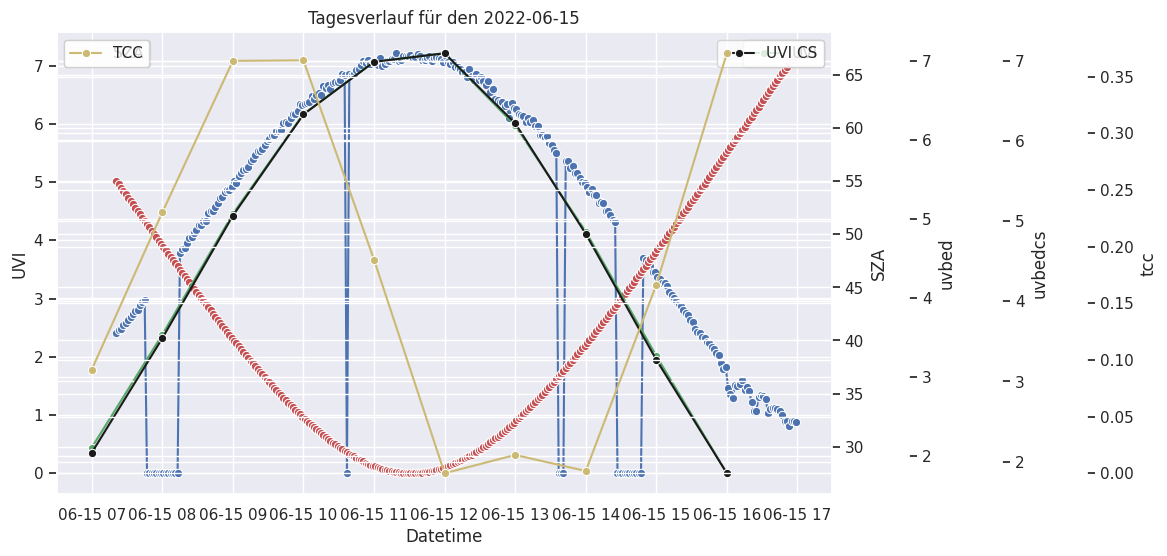

In [ ]:
cols_to_plot = ['UVI', 'SZA', 'aod469', 'uvbed', 'uvbedcs', 'tcc']
create_daily_plots(df_plot_daily[0:300], cols_to_plot)

## Variablitätsindizes berechen:

## Korrelation der Stündlichen Mittelwerte:

Berechnen der Varabilitätsindices Indizes:

In [ ]:
df_corr_hour = pd.concat([df_UVI_hourly[['UVI', 'SZA']], df_CAMS[['aod469', 'aod550', 'hcc', 'mcc', 'lcc', 'tcc', 'uvbed', 'uvbedcs']]], axis = 1)

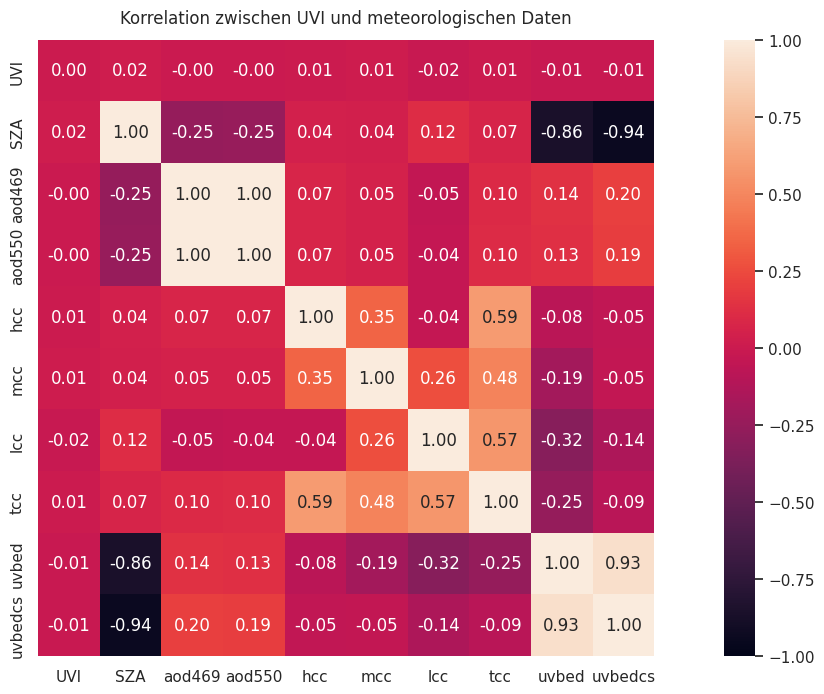

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize=(18, 8))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_corr_hour.corr(), fmt='.2f', vmin=-1, vmax=1, annot=True, square=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Korrelation zwischen UVI und meteorologischen Daten', fontdict={'fontsize':12}, pad=12);

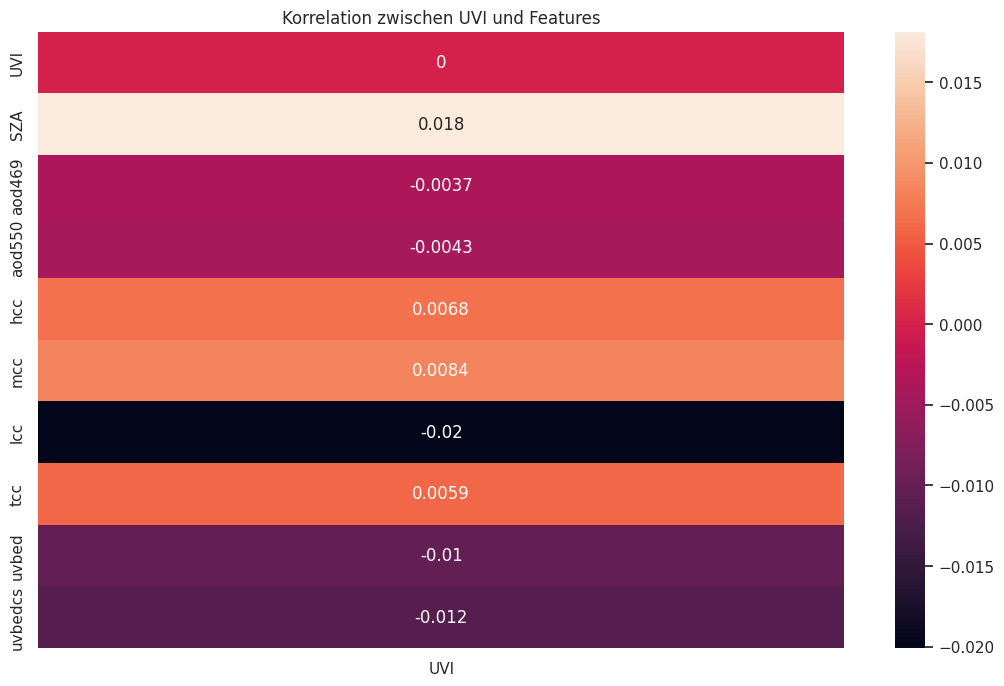

In [ ]:
sns.heatmap(df_corr_hour.corr()[['UVI']], annot=True)
plt.title('Korrelation zwischen UVI und Features');

## Kreuzkorrelation der Messwerte und der Vorhersagewerte:

https://towardsdatascience.com/how-to-do-an-eda-for-time-series-cbb92b3b1913

## Hauptkompinentenanlyse

- Anzahl der Merkmale reduzieren
- Visualisierung durch Dimensionsreduktion


In [ ]:
df_corr_PCA = pd.concat([df_UVI_hourly_withZero[['UVI', 'SZA']], df_CAMS[['aod469', 'aod550', 'hcc', 'lcc', 'tcc', 'uvbed', 'uvbedcs']]], axis = 1)

In [ ]:
df_corr_PCA

,UVI,SZA,aod469,aod550,hcc,lcc,tcc,uvbed,uvbedcs
Datetime,,,,,,,,,
2022-06-15 07:00:00,1.746515,52.061586,0.152110,0.121109,0.091481,0.000000,0.091481,2.109007,2.109151
2022-06-15 08:00:00,3.356615,44.471938,0.162309,0.129266,0.230113,0.000000,0.230113,3.538085,3.539376
2022-06-15 09:00:00,5.684107,36.261871,0.170056,0.135440,0.363832,0.000000,0.363832,5.067127,5.071212
2022-06-15 10:00:00,6.511567,30.133790,0.176425,0.140516,0.364290,0.000000,0.364290,6.330322,6.335601
2022-06-15 11:00:00,7.114456,27.689482,0.180305,0.143640,0.188470,0.000000,0.188470,6.991692,6.991999
...,...,...,...,...,...,...,...,...,...
2023-05-26 05:00:00,0.453827,73.676475,0.439879,0.354388,0.000000,0.004669,0.004669,0.286659,0.286764
2023-05-26 06:00:00,1.170444,64.313051,0.424471,0.342194,0.000000,0.001877,0.001877,0.814179,0.814284
2023-05-26 07:00:00,2.205628,54.880384,0.402243,0.324256,0.000000,0.008515,0.008515,1.755774,1.756089


In [ ]:
chi_square_value, p_value = calculate_bartlett_sphericity(df_corr_PCA)

/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [ ]:
p_value

nan

In [ ]:
# Daten standardisieren
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_corr_PCA)

In [ ]:
# PCA durchführen
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(scaled_data)

ValueError: ignored

In [ ]:
# Das Ergebnis anzeigen
print("PCA-Ergebnis:")
print(pca_result)

In [ ]:
plt.plot(pca_result)